<a href="https://colab.research.google.com/github/TarnNished/deep_learning_final/blob/main/data_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Storyteller — Data & Training

Full training notebook for image captioning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import random
from collections import Counter
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CONFIG = {
    "image_size": 224,
    "embedding_dim": 256,
    "hidden_dim": 512,
    "num_layers": 1,
    "batch_size": 32,
    "lr": 1e-3,
    "epochs": 25,
    "max_len": 30,
    "min_word_freq": 1
}


In [ ]:
if torch.cuda.is_available():
    print("using gpu")

using gpu


In [ ]:
DATA_ROOT = "/content/drive/MyDrive/caption_data"
IMAGE_DIR = os.path.join(DATA_ROOT, "Images")
CAPTIONS_FILE = os.path.join(DATA_ROOT, "captions.txt")
ARTIFACTS_DIR = "/content/drive/MyDrive/visual-storyteller/artifacts"


In [ ]:
torch.backends.cudnn.benchmark = True

def load_captions(image_dir, captions_file):

    samples = []

    with open(captions_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # remove header if exists
    if lines[0].lower().startswith("image"):
        lines = lines[1:]

    for line in lines:
        image_name, caption = line.strip().split(",", 1)
        image_path = os.path.join(image_dir, image_name)

        if os.path.exists(image_path):
            samples.append((image_path, caption.lower()))

    return samples


In [ ]:
all_samples = load_captions(IMAGE_DIR, CAPTIONS_FILE)
print("Total (image, caption) pairs:", len(all_samples))


Total (image, caption) pairs: 40455


In [ ]:

random.shuffle(all_samples)
train_end = int(0.8 * len(all_samples))
val_end = int(0.9 * len(all_samples))
train_data = all_samples[:train_end]
val_data = all_samples[train_end:val_end]
test_data = all_samples[val_end:]


In [ ]:

SPECIAL_TOKENS = {"<pad>":0,"<bos>":1,"<eos>":2,"<unk>":3}

def build_vocab(captions, min_freq):
    counter = Counter()
    for c in captions:
        counter.update(c.split())
    vocab = dict(SPECIAL_TOKENS)
    idx = len(vocab)
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

vocab = build_vocab([c for _, c in train_data], CONFIG["min_word_freq"])
ivocab = {i:w for w,i in vocab.items()}
vocab_size = len(vocab)


In [ ]:

def encode_caption(caption, vocab, max_len):
    tokens = caption.split()
    encoded = [vocab.get(w, vocab["<unk>"]) for w in tokens]
    encoded = [vocab["<bos>"]] + encoded + [vocab["<eos>"]]
    encoded = encoded[:max_len]
    encoded += [vocab["<pad>"]] * (max_len - len(encoded))
    return torch.tensor(encoded)


In [ ]:

class CaptionDataset(Dataset):
    def __init__(self, data, vocab, transform):
        self.data = data
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, caption = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        cap = encode_caption(caption, self.vocab, CONFIG["max_len"])
        return img, cap


In [ ]:

transform = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_loader = DataLoader(
    CaptionDataset(train_data, vocab, transform),
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:

class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        resnet = models.resnet18(pretrained=True)

        # Keep spatial map: (B, 512, 7, 7)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        self.conv_proj = nn.Conv2d(512, embed_dim, kernel_size=1)

    def forward(self, images):
        """
        images: (B, 3, 224, 224)
        returns: (B, 49, embed_dim)
        """
        feats = self.backbone(images)         # (B, 512, 7, 7)
        feats = self.conv_proj(feats)         # (B, E, 7, 7)

        feats = feats.flatten(2)              # (B, E, 49)
        feats = feats.permute(0, 2, 1)        # (B, 49, E)

        return feats


In [ ]:
class Attention(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.encoder_att = nn.Linear(embed_dim, hidden_dim)
        self.decoder_att = nn.Linear(hidden_dim, hidden_dim)
        self.full_att = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_feats, hidden_state):
        """
        encoder_feats: (B, 49, E)
        hidden_state: (B, H)
        """
        att1 = self.encoder_att(encoder_feats)           # (B, 49, H)
        att2 = self.decoder_att(hidden_state).unsqueeze(1)  # (B, 1, H)

        scores = self.full_att(torch.tanh(att1 + att2))  # (B, 49, 1)
        alpha = torch.softmax(scores, dim=1)             # (B, 49, 1)

        context = (encoder_feats * alpha).sum(dim=1)     # (B, E)
        return context, alpha


In [ ]:
class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = Attention(embed_dim, hidden_dim)

        self.lstm = nn.LSTMCell(embed_dim * 2, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.init_h = nn.Linear(embed_dim, hidden_dim)
        self.init_c = nn.Linear(embed_dim, hidden_dim)

    def init_hidden(self, encoder_feats):
        mean_feats = encoder_feats.mean(dim=1)
        h = self.init_h(mean_feats)
        c = self.init_c(mean_feats)
        return h, c

    def forward(self, encoder_feats, captions):
        """
        encoder_feats: (B, 49, E)
        captions: (B, T)
        """
        B, T = captions.shape
        embeddings = self.embedding(captions)

        h, c = self.init_hidden(encoder_feats)

        outputs = []

        for t in range(T - 1):
            context, _ = self.attention(encoder_feats, h)
            lstm_input = torch.cat([embeddings[:, t], context], dim=1)

            h, c = self.lstm(lstm_input, (h, c))
            outputs.append(self.fc(h))

        return torch.stack(outputs, dim=1)


In [ ]:

encoder = Encoder(CONFIG["embedding_dim"]).to(DEVICE)
decoder = DecoderWithAttention(
    vocab_size,
    CONFIG["embedding_dim"],
    CONFIG["hidden_dim"]
).to(DEVICE)

# Freeze all CNN layers first
for p in encoder.backbone.parameters():
    p.requires_grad = False

# Unfreeze last ResNet blocks (fine-tuning)
for p in encoder.backbone[-1:].parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: 0
Device name: Tesla T4


In [ ]:
train_losses = []
for epoch in range(CONFIG["epochs"]):
    encoder.backbone.eval()
    encoder.backbone[-1:].train()
    decoder.train()

    total_loss = 0
    for images, captions in tqdm(train_loader):
        images, captions = images.to(DEVICE), captions.to(DEVICE)

        optimizer.zero_grad()

        feats = encoder(images)
        outputs = decoder(feats, captions)

        loss = criterion(
            outputs.reshape(-1, vocab_size),
            captions[:, 1:].reshape(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(train_loader)
    train_losses.append(avg)
    print(f"Epoch {epoch+1}: loss={avg:.4f}")


100%|██████████| 1012/1012 [08:17<00:00,  2.03it/s]


Epoch 1: loss=4.4938


100%|██████████| 1012/1012 [04:20<00:00,  3.89it/s]


Epoch 2: loss=3.5815


100%|██████████| 1012/1012 [04:22<00:00,  3.86it/s]


Epoch 3: loss=3.2037


100%|██████████| 1012/1012 [04:20<00:00,  3.88it/s]


Epoch 4: loss=2.9489


100%|██████████| 1012/1012 [04:21<00:00,  3.87it/s]


Epoch 5: loss=2.7498


100%|██████████| 1012/1012 [04:20<00:00,  3.88it/s]


Epoch 6: loss=2.5827


100%|██████████| 1012/1012 [04:18<00:00,  3.91it/s]


Epoch 7: loss=2.4371


100%|██████████| 1012/1012 [04:18<00:00,  3.91it/s]


Epoch 8: loss=2.3081


100%|██████████| 1012/1012 [04:19<00:00,  3.90it/s]


Epoch 9: loss=2.1867


100%|██████████| 1012/1012 [04:19<00:00,  3.89it/s]


Epoch 10: loss=2.0766


100%|██████████| 1012/1012 [04:23<00:00,  3.84it/s]


Epoch 11: loss=1.9712


100%|██████████| 1012/1012 [04:19<00:00,  3.90it/s]


Epoch 12: loss=1.8710


100%|██████████| 1012/1012 [04:19<00:00,  3.90it/s]


Epoch 13: loss=1.7777


100%|██████████| 1012/1012 [04:19<00:00,  3.91it/s]


Epoch 14: loss=1.6868


100%|██████████| 1012/1012 [04:20<00:00,  3.89it/s]

Epoch 15: loss=1.6005


In [ ]:
def evaluate(loader, encoder, decoder):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in loader:
            images = images.to(DEVICE)
            captions = captions.to(DEVICE)

            feats = encoder(images)
            outputs = decoder(feats, captions)

            loss = criterion(
                outputs[:, 1:, :].reshape(-1, vocab_size),
                captions[:, 1:].reshape(-1)
            )
            total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:

os.makedirs("artifacts", exist_ok=True)
torch.save({"encoder":encoder.state_dict(),
            "decoder":decoder.state_dict()}, "artifacts/model.pt")
json.dump(vocab, open("artifacts/vocab.json","w"))
json.dump(CONFIG, open("artifacts/config.json","w"))
print("Saved artifacts")


Saved artifacts


In [ ]:
encoder.eval()
decoder.eval()

encoder.to(DEVICE)
decoder.to(DEVICE)


DecoderWithAttention(
  (embedding): Embedding(8342, 256)
  (attention): Attention(
    (encoder_att): Linear(in_features=256, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
  )
  (lstm): LSTMCell(512, 512)
  (fc): Linear(in_features=512, out_features=8342, bias=True)
  (init_h): Linear(in_features=256, out_features=512, bias=True)
  (init_c): Linear(in_features=256, out_features=512, bias=True)
)

In [ ]:
def generate_caption_one(image_path, max_len=30):
    encoder.eval()
    decoder.eval()

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        encoder_feats = encoder(image)
        h, c = decoder.init_hidden(encoder_feats)

        word = torch.tensor([vocab["<bos>"]], device=DEVICE)
        caption_words = []

        for _ in range(max_len):
            emb = decoder.embedding(word)
            context, _ = decoder.attention(encoder_feats, h)

            lstm_input = torch.cat([emb, context], dim=1)
            h, c = decoder.lstm(lstm_input, (h, c))

            scores = decoder.fc(h)
            word = scores.argmax(dim=1)

            token_id = word.item()
            if token_id == vocab["<eos>"]:
                break

            caption_words.append(ivocab.get(token_id, "<unk>"))

    return " ".join(caption_words)


Image exists: True


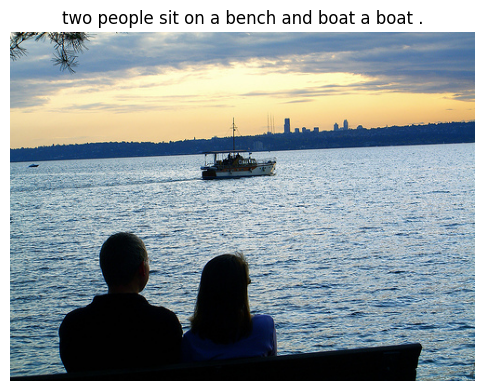

Generated caption: two people sit on a bench and boat a boat .


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_path = "/content/drive/MyDrive/caption_data/Images/44129946_9eeb385d77.jpg"

# Sanity check: file exists
print("Image exists:", os.path.exists(image_path))

# Generate caption
caption = generate_caption_one(image_path)

# Display image with caption
img = Image.open(image_path).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(caption)
plt.show()

print("Generated caption:", caption)
